In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
full_train_data = pd.read_csv("../data/train.csv")
print(full_train_data.head())
print(len(full_train_data))

       id                                             SMILES  Tg       FFV  \
0   87817                         *CC(*)c1ccccc1C(=O)OCCCCCC NaN  0.374645   
1  106919  *Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5... NaN  0.370410   
2  388772  *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(... NaN  0.378860   
3  519416  *Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)... NaN  0.387324   
4  539187  *Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N... NaN  0.355470   

         Tc  Density  Rg  
0  0.205667      NaN NaN  
1       NaN      NaN NaN  
2       NaN      NaN NaN  
3       NaN      NaN NaN  
4       NaN      NaN NaN  
7973


In [98]:
import os
import math
import json
from typing import List, Tuple, Dict
from datetime import datetime

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split
from torch.optim import Adam

from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader

from kmeans_hrm_model import KMeansCarry


SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Projektpfade und Trainingshyperparameter
PROJECT_ROOT = "/home/thomaspugh/projects/chem-properties"
DATA_CSV = os.path.join(PROJECT_ROOT, "data", "train.csv")
CHECKPOINT_DIR = os.path.join(PROJECT_ROOT, "checkpoints", "hrm")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

PROPERTIES = ["Tg", "FFV", "Tc", "Density", "Rg"]
TARGET_DIM = len(PROPERTIES)

# Trainingseinstellungen
EPOCHS = 5
BATCH_SIZE = 16
LR = 1e-3
WEIGHT_DECAY = 1e-4
CHECKPOINT_EVERY_N_STEPS = 100
K_HEADS = 16  # Size of the KMeansCarry.mask feature dimension (only interface, not used here)

# Optional: Limit the number of samples (None = all)
MAX_SAMPLES = 5

print(f"Using device: {device}")


Using device: cpu


In [104]:
from dataset_helpers import smiles_iter_to_graph_dataset
from data_gen_helpers import iterative_extend_smiles, count_non_hydrogen_atoms
from data_gen_helpers import logger as data_gen_logger
import logging
from datetime import datetime

data_gen_logger.setLevel(logging.DEBUG)

logger = logging.getLogger("main")
logger.setLevel(logging.DEBUG)
handler = logging.FileHandler(f"main_{datetime.now().strftime('%Y%m%d%H%M%S')}.log", mode="a")
handler.setLevel(logging.DEBUG)
logger.addHandler(handler)
data_gen_logger.addHandler(handler)


# Load data
VAL_RATIO = 0.1

# Load CSV
raw_df = pd.read_csv(DATA_CSV)
raw_df = raw_df[["SMILES"] + PROPERTIES].dropna(subset=["SMILES"])
if MAX_SAMPLES is not None:
    raw_df = raw_df.iloc[:MAX_SAMPLES].reset_index(drop=True)

print(f"Original dataset size: {len(raw_df)}")

# Extend SMILES to reach at least 25 atoms (excluding hydrogen)
extended_data = []
failed_extensions = []

for idx, row in raw_df.iterrows():
    original_smiles = row["SMILES"]
    original_atoms = count_non_hydrogen_atoms(original_smiles)
    
    if idx % 50 == 0 or idx == len(raw_df) - 1:
        print(f"Processing reached {idx+1}/{len(raw_df)}: {original_smiles} ({original_atoms} atoms)")
    
    try:
        # Generate extended SMILES with at least 100 atoms (realistic value)
        extensions = list(iterative_extend_smiles(
            original_smiles, 
            min_length=100, 
            max_output=10,  # 10 variants
        ))
        
        if extensions:
            # Use the first successful extension
            for extended_smiles, monomer_count in extensions:
                final_atoms = count_non_hydrogen_atoms(extended_smiles)
                
                # Create new row with extended SMILES
                new_row = row.copy()
                new_row["SMILES"] = extended_smiles
                new_row["monomer_count"] = monomer_count
                new_row["original_smiles"] = original_smiles
                new_row["original_atoms"] = original_atoms
                new_row["final_atoms"] = final_atoms
                extended_data.append(new_row)
            logger.debug(f"  -> Success: {len(extensions)} molecules for {original_smiles} ({final_atoms} atoms)")
        else:
            failed_extensions.append((idx, original_smiles, "No extensions generated"))
            logger.debug(f"  -> Failed: No extensions generated")
            
    except Exception as e:
        failed_extensions.append((idx, original_smiles, str(e)))
        logger.debug(f"  -> Failed: {e}")

AUX_INFO = ["monomer_count", "original_atoms", "final_atoms", "SMILES"]

# Create new DataFrame with extended SMILES
extended_df = pd.DataFrame(extended_data)
print(f"\nSuccessfully extended: {len(extended_df)} molecules")
print(f"Failed extensions: {len(failed_extensions)}")

if len(failed_extensions) > 0:
    logger.debug("\n\nFailed molecules:\n\n")
    for idx, smiles, error in failed_extensions:  # Show first 5 errors
        logger.debug(f"  {idx}: {smiles} - {error}")

# Use extended data for training
if len(extended_df) == 0:
    raise RuntimeError("No molecules could be extended. Check your data and extension logic.")

# Split into Train/Val
num_rows = len(extended_df)
perm = np.random.RandomState(SEED).permutation(num_rows)
train_count = int((1.0 - VAL_RATIO) * num_rows)
train_idx, val_idx = perm[:train_count], perm[train_count:]
train_df = extended_df.iloc[train_idx].reset_index(drop=True)
val_df = extended_df.iloc[val_idx].reset_index(drop=True)

# Create graph datasets
train_dataset = smiles_iter_to_graph_dataset(train_df["SMILES"], torch.tensor(train_df[PROPERTIES].to_numpy(), dtype=torch.float32, device=device), aux_info=train_df[AUX_INFO])
val_dataset = smiles_iter_to_graph_dataset(val_df["SMILES"], torch.tensor(val_df[PROPERTIES].to_numpy(), dtype=torch.float32, device=device), aux_info=val_df[AUX_INFO])

print(f"example aux_info: {train_dataset[0].aux_info}")
print(f"Train graphs: {len(train_dataset)} | Val graphs: {len(val_dataset)}")

# DataListLoader (batched lists of Data objects)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Derive input dimension from first training graph
if len(train_dataset) == 0:
    raise RuntimeError("Training dataset is empty after preprocessing.")
INPUT_DIM = train_dataset[0].x.shape[1]
print(f"Input dim: {INPUT_DIM}, Target dim: {TARGET_DIM}")

EDGE_DIM = train_dataset[0].edge_attr.shape[1]
print(f"Edge dim: {EDGE_DIM}")

# Show some examples of the extensions
print(f"\nExamples of SMILES extensions:")
for i in range(min(3, len(train_df))):
    row = train_df.iloc[i]
    print(f"Original ({row.get('original_atoms', 'N/A')} atoms): {row.get('original_smiles', 'N/A')}")
    print(f"Extended ({row.get('final_atoms', 'N/A')} atoms): {row['SMILES']}")
    print()

TOTAL_BATCH_COUNT = len(train_loader)


Original dataset size: 5
Processing reached 1/5: *CC(*)c1ccccc1C(=O)OCCCCCC (17 atoms)


The SMILES writer does not write stereochemical information
The SMILES writer does not write stereochemical information
The SMILES writer does not write stereochemical information
The SMILES writer does not write stereochemical information
The SMILES writer does not write stereochemical information
The SMILES writer does not write stereochemical information
The SMILES writer does not write stereochemical information
The SMILES writer does not write stereochemical information


Processing reached 5/5: *Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N+](=O)[O-])cc3)c(C(*)=O)cc2OCCCCCCCCCOCC2CCCN2c2ccc([N+](=O)[O-])cc2)cc1 (70 atoms)

Successfully extended: 24 molecules
Failed extensions: 0
example aux_info: [3 17 87
 'CCCCCCOC(=O)c1ccccc1C(C)CC(CCC(CC(CC(C)c1ccccc1C(=O)OCCCCCC)c1ccccc1C(=O)OCCCCCC)c1ccccc1C(=O)OCCCCCC)c1ccccc1C(=O)OCCCCCC']
Train graphs: 21 | Val graphs: 3
Input dim: 6, Target dim: 5
Edge dim: 4

Examples of SMILES extensions:
Original (17 atoms): *CC(*)c1ccccc1C(=O)OCCCCCC
Extended (87 atoms): CCCCCCOC(=O)c1ccccc1C(C)CC(CCC(CC(CC(C)c1ccccc1C(=O)OCCCCCC)c1ccccc1C(=O)OCCCCCC)c1ccccc1C(=O)OCCCCCC)c1ccccc1C(=O)OCCCCCC

Original (42 atoms): *Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)c(-c3ccc(C)cc3)c2-c2ccc(C)cc2)cc1
Extended (128 atoms): CNc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(NNc3c(-c4ccc(C)cc4)c(-c4ccc(C)cc4)c(-c4ccc(NNc5ccc(-c6c(-c7ccc(C)cc7)c(-c7ccc(C)cc7)c(NC)c(-c7ccc(C)cc7)c6-c6ccc(C)cc6)cc5)cc4)c(-c4ccc(C)cc4)c3-c3ccc(C)cc3)c(-c3ccc(C)cc

In [105]:
# Use KMeansHRMModule from kmeans_hrm_model.py
from kmeans_hrm_model import (
    KMeansHRMModule, KMeansHRMConfig, KMeansHRMInnerModuleConfig, KMeansHRMInitialCarry,
    KMeansConfig, KMeansHeadConfig, OutputHeadConfig,
    SpectralWeighting, SpectralWeightingConfig,
    DiscreteMeanCenter, DiscreteMeanCenterConfig,
    RadiusAttentionWeights, RadiusMaskConfig
)

from torch_geometric.nn import GATConv

def count_parameters(model):
    """Anzahl der trainierbaren Parameter im Modell zählen"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def create_kmeans_hrm_config(input_dim: int, edge_dim: int, hidden_dim: int = 128, latent_dim: int = 128, output_dim: int = TARGET_DIM, k: int = K_HEADS) -> KMeansHRMConfig:
    
    # Spectral Weighting Configuration
    spectral_config = SpectralWeightingConfig(
        node_channels=latent_dim,
        K=3,  # Chebyshev polynomial order
        num_layers=2,
        normalization='sym',
        bias=True,
        dropout=0.2,
        norm='batch',
        norm_kwargs={'in_channels': latent_dim}
    )
    
    # Center Module Configuration
    center_config = DiscreteMeanCenterConfig(
        distance_metric='euclidean'
    )
    
    # Radius Mask Configuration (simplified weighting module)
    radius_weighting = GATConv(latent_dim, latent_dim)
    radius_config = RadiusMaskConfig(
        max_num_neighbors=25,
        radius=20,
        weighting_module=radius_weighting,
        threshold=0.1,
        node_dim=latent_dim
    )
    
    # KMeans Head Configuration
    kmeans_head_config = KMeansHeadConfig(
        node_count=k,
        node_dim=latent_dim,
        max_nodes=100,  
        num_layers=5,
        dropout=0.2,
        weighting_module=SpectralWeighting(spectral_config),
        center_module=DiscreteMeanCenter(center_config),
        mask_module=RadiusAttentionWeights(radius_config),
        act='relu',
        act_kwargs={}
    )
    
    # KMeans Configuration
    kmeans_config = KMeansConfig(
        k=k,
        max_iter=10,
        thresh=1e-6,
        max_overlap=2,
        head_module=kmeans_head_config,
        excluded_is_cluster=True
    )
    
    # Output Head Configuration
    output_head_config = OutputHeadConfig(
        node_dim=latent_dim,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        pooling_type='mean',
        norm='batch',
        norm_kwargs={'in_channels': hidden_dim},
        act='relu',
        act_kwargs={}
    )
    
    # Policy Module Configuration (für Halt-Entscheidungen)
    policy_config = OutputHeadConfig(
        node_dim=latent_dim,
        hidden_dim=hidden_dim//2,
        output_dim=2,  # halt=0, continue=1
        pooling_type='mean',
        norm='batch',
        norm_kwargs={'in_channels': hidden_dim//2},
        act='relu',
        act_kwargs={}
    )
    
    # Inner Module Configuration
    inner_config = KMeansHRMInnerModuleConfig(
        add_self_loops=True,
        add_negative_edges=True,
        dropout=0.2,
        hidden_dim=hidden_dim,        # inner-side hidden size, reused
        node_dim=latent_dim,          # must equal vgae_latent_dim
        attention_dim=16,           # bigger in final
        edge_dim=edge_dim,
        layers=3,
        kmeans_config=kmeans_config,
        output_head_config=output_head_config,
        policy_module_config=policy_config,
        K_cycles=2,
        L_cycles=2,
        batch_size=BATCH_SIZE,
        halt_max_steps=5,
        halt_exploration_prob=0.1,
    )
    
    # Hauptkonfiguration
    config = KMeansHRMConfig(
        inner_module=inner_config,
        explore_steps_prob=0.1,
        halt_max_steps=5,
        pre_encoder_conv_layers=2,
        vgae_encoder_type="cheb",
        input_dim=input_dim,
        edge_attr_dim=edge_dim,
        vgae_latent_dim=latent_dim,           # must equal inner.node_dim
        vgae_encoder_layers=2,
        vgae_encoder_dropout=0.1,
        vgae_decoder_type=None,
        vgae_kl_weight=1.0,
    )
    
    return config

# Modell initialisieren
hrm_config = create_kmeans_hrm_config(INPUT_DIM, EDGE_DIM, latent_dim=4, hidden_dim=4, output_dim=TARGET_DIM, k=2)
model = KMeansHRMModule(hrm_config, training=True).to(device)
optimizer = Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Print number of parameters
num_params = count_parameters(model)
print(f"KMeansHRMModule created with {num_params:,} trainable parameters")
print(f"Model size: {num_params * 4 / 1024 / 1024:.2f} MB (float32)")
print(model)


KMeansHRMModule created with 7,378 trainable parameters
Model size: 0.03 MB (float32)
KMeansHRMModule(
  (inner_module): KMeansHRMInnerModule(
    (kmeans_module): KMeans(
      (heads): ModuleList(
        (0-1): 2 x KMeansHead(
          (weighting_module): SpectralWeighting(
            (cheb_convs): ModuleList(
              (0-1): 2 x ChebConv(4, 4, K=3, normalization=sym)
            )
            (norms): ModuleList(
              (0-1): 2 x BatchNorm(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
          )
          (center_module): DiscreteMeanCenter(
            (distance_module): PairwiseDistance()
          )
          (mask_module): RadiusAttentionWeights(
            (weighting_module): GATConv(4, 4, heads=1)
            (_mask_linear): Linear(in_features=4, out_features=1, bias=True)
          )
          (act): ReLU()
        )
      )
    )
    (vgae_encoder): VGAEEncoder(
      (norms): ModuleList(
        (0-14): 15 x LayerNorm(16,

In [ ]:
# Loss: Range-violation for missing, otherwise MSE
# Note: HRM-repo inspiration (loss splitting, early checkpoints), see links below
# - losses.py and pretrain.py from HRM (only as idea source)
import numpy as np
from typing import Union, List
from training_loops import composite_loss, compute_mae_in_bounds

Loss and metrics initialized.


In [111]:
from typing import TypedDict, Dict, Any
from dataclasses import dataclass


def save_checkpoint(state: Dict, step: int, is_best: bool = False):
    path = os.path.join(CHECKPOINT_DIR, f"step_{step}.pt")
    torch.save(state, path)
    if is_best:
        best_path = os.path.join(CHECKPOINT_DIR, "best.pt")
        torch.save(state, best_path)


class PretrainConfig(TypedDict):
    # Data
    data_path: str

    # Hyperparams
    global_batch_size: int
    epochs: int
    total_iters: int

    lr: float
    lr_min_ratio: float
    lr_warmup_steps: int

    weight_decay: float
    beta1: float
    beta2: float


@dataclass
class TrainState:
    model: nn.Module
    optimizer: torch.optim.Optimizer
    carry: KMeansHRMInitialCarry | None

    step: int
    total_steps: int


def compute_warmup_weight(step: int, warmup_steps: int, min_ratio: float) -> float:
    if warmup_steps <= 0:
        return 1.0
    if step < warmup_steps:
        # Linear warmup from min_ratio -> 1.0
        return float(min_ratio + (1.0 - min_ratio) * (step / max(1, warmup_steps)))
    return 1.0


def pack_train_state_for_save(ts: TrainState) -> Dict[str, Any]:
    return {
        "step": int(ts.step),
        "total_steps": int(ts.total_steps),
        # Carry can be large; still useful for exact resume within the same batch sequence
        "carry": ts.carry,
    }


def train_batch(epoch: int, train_state: TrainState, batch_data: Batch, config: PretrainConfig) -> Dict[str, float]:
    model = train_state.model
    optimizer = train_state.optimizer

    model.train()

    # Targets [B,5]
    y = torch.stack([g.y for g in batch_data.to_data_list()], dim=0).to(device)
    batch_data = batch_data.to(device)
    related_info = batch_data.aux_info

    # Reuse existing carry if provided; otherwise initialize
    if train_state.carry is None:
        print(f"Initializing new carry for batch {batch_data.batch.shape[0]}")
        train_state.carry = model.initial_carry(batch_data)

    # Forward
    train_state.carry, hrm_output = model(train_state.carry, batch_data)
    preds = hrm_output['y_pred']

    loss = composite_loss(preds, y, related_info)
    train_state.step += 1
    warmup_w = compute_warmup_weight(train_state.step, config["lr_warmup_steps"], config["lr_min_ratio"])  # type: ignore[index]
    scaled_loss = loss * warmup_w * (1.0 / TOTAL_BATCH_COUNT)

    # Backward/update
    optimizer.zero_grad()
    scaled_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
    optimizer.step()

    # Metrics (unscaled loss for logging)
    with torch.no_grad():
        metrics = compute_mae_in_bounds(preds, y, related_info)
        metrics.update({
            "loss": loss.item(),
            "warmup_weight": float(warmup_w),
        })


    # Periodic checkpoint
    global_step = train_state.step
    if global_step % CHECKPOINT_EVERY_N_STEPS == 0:
        save_checkpoint({
            "epoch": epoch,
            "global_step": global_step,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "model_class": model.__class__.__name__,
            "model_module": model.__class__.__module__,
            "train_state": pack_train_state_for_save(train_state),
        }, step=global_step)

    return metrics


@torch.no_grad()
def validate(epoch: int, model: nn.Module, loader: DataLoader) -> Dict[str, float]:
    model.eval()
    running_loss = 0.0
    mae_accum = {f"mae_{p}": 0.0 for p in PROPERTIES}
    count_samples = 0

    for batch_data in loader:
        y = torch.stack([g.y for g in batch_data.to_data_list()], dim=0).to(device)
        batch_data = batch_data.to(device)
        related_info = batch_data.aux_info
        
        carry = model.initial_carry(batch_data)
        _, hrm_output = model(carry, batch_data)
        preds = hrm_output['y_pred']

        loss = composite_loss(preds, y, related_info)

        metrics = compute_mae_in_bounds(preds, y, related_info)
        for k, v in metrics.items():
            if not math.isnan(v):
                mae_accum[k] += v * preds.size(0)
        running_loss += loss.item() * preds.size(0)
        count_samples += preds.size(0)

    avg_loss = running_loss / max(1, count_samples)
    avg_mae = {k: (v / max(1, count_samples)) for k, v in mae_accum.items()}

    return {"loss": avg_loss, **avg_mae}


# Build a minimal config for warmup from existing hyperparams
CONFIG: PretrainConfig = {
    "data_path": DATA_CSV,
    "global_batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    # Step-based training support; used by helper loop
    "total_iters": int(EPOCHS * len(train_loader)),
    "lr": LR,
    "lr_min_ratio": 0.1,
    "lr_warmup_steps": max(1, len(train_loader) * 2),  # warm up first ~2 epochs of steps
    "weight_decay": WEIGHT_DECAY,
    "beta1": 0.9,
    "beta2": 0.999,
}


history = {"train": [], "val": []}
best_val_loss = float("inf")

# Initialize TrainState with total steps estimated from loader length and epochs
train_state = TrainState(
    model=model,
    optimizer=optimizer,
    carry=None,
    step=0,
    total_steps=CONFIG["epochs"] * len(train_loader)
)

for epoch in range(1, CONFIG["epochs"] + 1):
    # Accumulators for epoch
    running_loss = 0.0
    mae_accum = {f"mae_{p}": 0.0 for p in PROPERTIES}
    count_samples = 0

    for batch_data in train_loader:
        metrics = train_batch(epoch, train_state, batch_data, CONFIG)
        batch_size_effective = batch_data.num_graphs if hasattr(batch_data, 'num_graphs') else BATCH_SIZE

        running_loss += metrics["loss"] * batch_size_effective
        for k in list(mae_accum.keys()):
            prop_name = k.split("mae_")[-1]
            if f"mae_{prop_name}" in metrics and not math.isnan(metrics[f"mae_{prop_name}"]):
                mae_accum[k] += metrics[f"mae_{prop_name}"] * batch_size_effective
        count_samples += batch_size_effective

    train_stats = {
        "loss": running_loss / max(1, count_samples),
        **{k: (v / max(1, count_samples)) for k, v in mae_accum.items()},
    }

    val_stats = validate(epoch, train_state.model, val_loader)

    history["train"].append({"epoch": epoch, **train_stats})
    history["val"].append({"epoch": epoch, **val_stats})

    is_best = val_stats["loss"] < best_val_loss
    if is_best:
        best_val_loss = val_stats["loss"]

    save_checkpoint({
        "epoch": epoch,
        "model_state": train_state.model.state_dict(),
        "optimizer_state": train_state.optimizer.state_dict(),
        "train_stats": train_stats,
        "val_stats": val_stats,
        "model_class": train_state.model.__class__.__name__,
        "model_module": train_state.model.__class__.__module__,
        "train_state": pack_train_state_for_save(train_state),
    }, step=epoch, is_best=is_best)

    print(f"Epoch {epoch:03d} | train_loss={train_stats['loss']:.4f} | val_loss={val_stats['loss']:.4f}")



Initializing new carry for batch 1812


IndexError: index 902 is out of bounds for dimension 0 with size 491

In [ ]:
from training_loops import load_checkpoint
import glob

# Restore model/optimizer/train_state from a checkpoint (best.pt preferred)
best_path = os.path.join(CHECKPOINT_DIR, "best.pt")
chosen_path = None
if os.path.isfile(best_path):
    chosen_path = best_path
else:
    candidates = sorted(glob.glob(os.path.join(CHECKPOINT_DIR, "step_*.pt")))
    if len(candidates) > 0:
        # Choose the numerically largest step
        def _step_num(p):
            try:
                base = os.path.basename(p)
                num = int(base.replace("step_", "").replace(".pt", ""))
                return num
            except Exception:
                return -1
        candidates.sort(key=_step_num)
        chosen_path = candidates[-1]

if chosen_path:
    raw_state, saved_ts = load_checkpoint(chosen_path, model, optimizer, map_location=device)
    if isinstance(saved_ts, dict):
        try:
            train_state.step = int(saved_ts.get("step", train_state.step))
            train_state.total_steps = int(saved_ts.get("total_steps", train_state.total_steps))
            train_state.carry = saved_ts.get("carry", None)
        except Exception:
            pass
    print(f"Loaded checkpoint: {chosen_path} | step={train_state.step}")
else:
    print("No checkpoint found to load.")



In [ ]:
from training_loops import train_until_total_iters

# If you want to override step budget, set CONFIG["total_iters"] directly
TOTAL_ITERS = int(CONFIG.get("total_iters", EPOCHS * len(train_loader)))
print(f"Training until total_iters = {TOTAL_ITERS}")

# Run the total_iters-driven loop
history_step, best_val_loss = train_until_total_iters(
    total_iters=TOTAL_ITERS,
    start_epoch=1,
    train_state=train_state,
    train_loader=train_loader,
    val_loader=val_loader,
    config=CONFIG,
    train_batch_fn=train_batch,
    validate_fn=validate,
    save_checkpoint_fn=save_checkpoint,
    checkpoint_every_n=CHECKPOINT_EVERY_N_STEPS,
    print_every_n=25,
)

# Merge history into the existing one for convenience
history["train"].extend(history_step["train"])  # type: ignore[index]
history["val"].extend(history_step["val"])      # type: ignore[index]
print(f"Done total_iters training. best_val_loss={best_val_loss:.4f}")



Saved metrics to /home/thomaspugh/projects/chem-properties/checkpoints/hrm/history.json


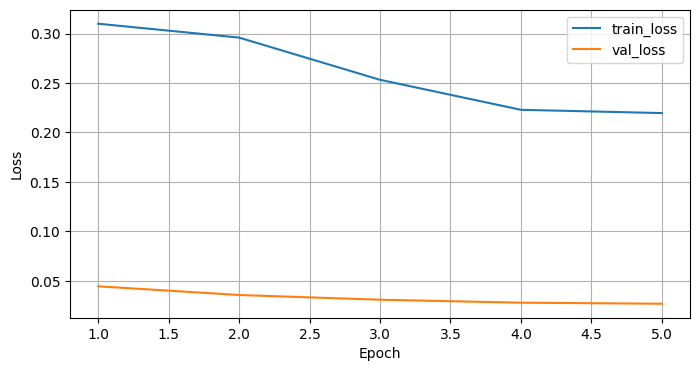

In [103]:

import matplotlib.pyplot as plt


metrics_path = os.path.join(CHECKPOINT_DIR, "history.json")
with open(metrics_path, "w") as f:
    json.dump(history, f, indent=2)
print(f"Saved metrics to {metrics_path}")

# Plot
def plot_curves(history):
    epochs = [e["epoch"] for e in history["train"]]
    train_losses = [e["loss"] for e in history["train"]]
    val_losses = [e["loss"] for e in history["val"]]

    plt.figure(figsize=(8,4))
    plt.plot(epochs, train_losses, label="train_loss")
    plt.plot(epochs, val_losses, label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_curves(history)

# Hinweis auf Quellen (Inspiration):
# - HRM Losses und Training (nur als Anregung, nicht 1:1):
#   https://github.com/sapientinc/HRM/blob/05dd4ef795a98c20110e380a330d0b3ec159a46b/models/losses.py
#   https://github.com/sapientinc/HRM/blob/05dd4ef795a98c20110e380a330d0b3ec159a46b/pretrain.py
